In [8]:
import scipy.io as sio

mat_file = "../data/mpii_human_pose/mpii_human_pose.mat"
mat_data = sio.loadmat(mat_file, struct_as_record=False)
release_data = mat_data['RELEASE']

obj_rel = release_data[0,0] 
annolist = obj_rel.__dict__['annolist'] 
img_train = obj_rel.__dict__['img_train']
act = obj_rel.__dict__['act']

print(annolist.shape, img_train.shape, act.shape)

(1, 24987) (1, 24987) (24987, 1)


In [9]:
import numpy as np

keypoints_list = []
images_list = []
head_boxes_list = []

for ix in range(0, annolist.shape[1]):

    # Extract annotation for each image
    rect = annolist[0, ix].__dict__['annorect']

    if rect.shape[0] == 0:
        continue  # No annotation for this image
    
    obj_rect = rect[0, 0]

    # Extract head box
    head_box = []
    if 'x1' in obj_rect.__dict__ and 'y1' in obj_rect.__dict__ and 'x2' in obj_rect.__dict__ and 'y2' in obj_rect.__dict__:
        x1 = obj_rect.x1.item()
        y1 = obj_rect.y1.item()
        x2 = obj_rect.x2.item()
        y2 = obj_rect.y2.item()
        
        # Append head box to the list
        head_box.append([x1, y1, x2, y2])  # x1, y1, x2, y2
    else:
        continue  # Skip this image if no head box

    # Extract keypoints if available
    if 'annopoints' not in obj_rect.__dict__ or obj_rect.__dict__['annopoints'].shape[0] == 0:
        continue  # No keypoints for this image
    
    annopoints = obj_rect.__dict__['annopoints']
    obj_points = annopoints[0, 0]
    points = obj_points.__dict__['point']

    if points.shape[1] > 0:
        points_values = []
        for point in points[0, :]:
            x_value = point.x.item()  # Extract x-coordinate
            y_value = point.y.item()  # Extract y-coordinate

            points_values.append([x_value, y_value])  # Append point as [x, y]

        
        if len(points_values) == 16:
            # Append to the lists
            keypoints_list.append(points_values)
            head_boxes_list.append(head_box[0])  # We only store one head box for each image

            # Store corresponding image
            image = annolist[0, ix].__dict__['image'][0, 0].__dict__['name'][0]
            images_list.append(image)

# Convert lists to numpy arrays

# id - joint id (0 - r ankle, 1 - r knee, 2 - r hip, 3 - l hip, 4 - l knee, 5 - l ankle, 6 - pelvis, 7 - thorax, 8 - upper neck, 9 - \ 
    # head top, 10 - r wrist, 11 - r elbow, 12 - r shoulder, 13 - l shoulder, 14 - l elbow, 15 - l wrist)
keypoints_array = np.array(keypoints_list, dtype=object)
images_array = np.array(images_list, dtype=object)
head_boxes_array = np.array(head_boxes_list, dtype=object)

# Debugging outputs
print(f"Total images: {images_array.shape[0]}")
print(f"Total images with keypoints: {keypoints_array.shape[0]}")
print(f"Total bounding boxes: {head_boxes_array.shape[0]}")

print(keypoints_array.shape, images_array.shape, head_boxes_array.shape)


Total images: 11232
Total images with keypoints: 11232
Total bounding boxes: 11232
(11232, 16, 2) (11232,) (11232, 4)


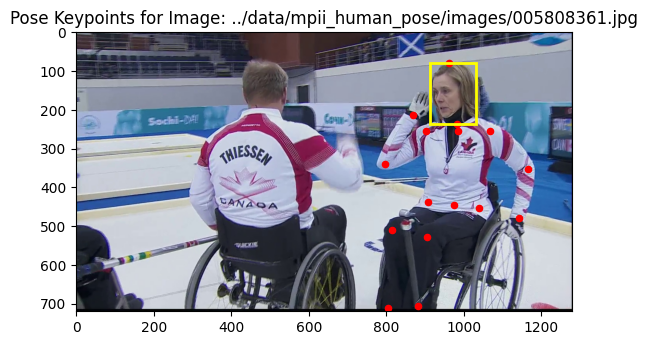

In [10]:
import cv2
import matplotlib.pyplot as plt
import os

# Test index
index = 1
image_filename = images_array[index] 
keypoints = keypoints_array[index]
head_box = head_boxes_array[index] 

# Construct the image path based on the filename and the folder where the images are stored
image_path = os.path.join('../data/mpii_human_pose/images/', image_filename)  

# Load the image using OpenCV
img = cv2.imread(image_path)
original_height, original_width = img.shape[:2]

# Plot the image with keypoints
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display in matplotlib

# Loop over each joint and plot its (x, y) coordinates
for i in range(len(keypoints)):  
    x = keypoints[i][0]
    y = keypoints[i][1]
    plt.scatter(x, y, color='red', s=20)  # Plot the keypoints as red dots

# Draw the head box (top-left and bottom-right corners)
x1, y1, x2, y2 = head_box
plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='yellow', linewidth=2))

plt.title(f'Pose Keypoints for Image: {image_path}')
plt.show()
